# Bell State and Identity Tomography

Perform QST in parallel on a number of pairs using qiskit experiments for a Bell state and the Ground state (identity). This is both meant as a characterization notebook, but also as an example of how the QST package performs.

In [210]:
import numpy as np
import rustworkx as rx
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit

from qiskit_experiments.framework import ParallelExperiment, BatchExperiment
from qiskit_experiments.library import StateTomography, MitigatedStateTomography

from qiskit_device_benchmarking.utilities import graph_utils as gu

In [285]:
# enter your device hub/group/project here
# and device

hgp = "ibm-q/open/main"

service = QiskitRuntimeService()
backend_real = service.backend("ibm_kyiv", instance=hgp)
nq = backend_real.configuration().n_qubits
coupling_map = backend_real.configuration().coupling_map

### Use RustworkX and Graph Utilities to Build Sets

Code below uses some of the graph utilities in the package to pull out several sets of isolated two qubit pairs.

In [286]:
# build a set of gates
G = gu.build_sys_graph(nq, coupling_map)
# get all length 2 paths in the device
paths = rx.all_pairs_all_simple_paths(G, 2, 2)
# flatten those paths into a list from the rustwork x iterator
paths = gu.paths_flatten(paths)
# remove permutations
paths = gu.remove_permutations(paths)
# convert to the coupling map of the device
paths = gu.path_to_edges(paths, coupling_map)
# make into separate sets
sep_sets = gu.get_separated_sets(G, paths, min_sep=2)

In [287]:
# state tomography of all the two qubit edgges in parallel
tomo_batch_list = []

# got through for each of the edge sets
for ii in range(len(sep_sets)):
    tomo_exp_list = []
    tomo_exp_list_b = []
    twoq_circ_b = QuantumCircuit(2)
    twoq_circ = QuantumCircuit(2)
    if 1:
        twoq_circ.h(0)
        twoq_circ.cx(0, 1)

    if "ecr" in backend_real.configuration().basis_gates:
        twoq_gate = "ecr"
    elif "cz" in backend_real.configuration().basis_gates:
        twoq_gate = "cz"

    for two_i, two_set in enumerate(sep_sets[ii]):
        tomo_exp = MitigatedStateTomography(
            circuit=twoq_circ, physical_qubits=two_set[0:2], backend=backend_real
        )
        tomo_exp_list.append(tomo_exp)

        tomo_exp = MitigatedStateTomography(
            circuit=twoq_circ_b, physical_qubits=two_set[0:2], backend=backend_real
        )
        tomo_exp_list_b.append(tomo_exp)

    tomo_exp_p = ParallelExperiment(
        tomo_exp_list, backend=backend_real, flatten_results=False
    )
    tomo_exp_pb = ParallelExperiment(
        tomo_exp_list_b, backend=backend_real, flatten_results=False
    )

    tomo_batch_list.append(tomo_exp_p)
    tomo_batch_list.append(tomo_exp_pb)

# back all of them together
full_tomo_exp = BatchExperiment(
    tomo_batch_list, backend=backend_real, flatten_results=False
)
full_tomo_exp.set_run_options(shots=1000)

# run
tomo_data = full_tomo_exp.run()

79.55134320259094


### Analyze the Data

First pull all the data into several giant lists. Then plot. Make the jobs have run first which can be probed with `tomo_data.analysis_status()`

In [ ]:
set_list = []
bell_err = []
id_err = []
gate_err = []
read_err = []
back_prop = backend_real.properties()
for i in range(len(sep_sets)):
    for j in range(len(sep_sets[i])):
        set_list.append(sep_sets[i][j])
        bell_err.append(
            1
            - tomo_data.child_data()[2 * i].child_data()[j].analysis_results()[1].value
        )
        id_err.append(
            1
            - tomo_data.child_data()[2 * i + 1]
            .child_data()[j]
            .analysis_results()[1]
            .value
        )
        gate_err.append(back_prop.gate_error(twoq_gate, set_list[-1]))
        read_err.append(
            1
            - (1 - back_prop.readout_error(set_list[-1][0])) ** 0.5
            * (1 - back_prop.readout_error(set_list[-1][1])) ** 0.5
        )
        print(
            "Q%s, bell error (purity) %.2e (%.2e)/ id error (purity) %.2e (%.2e)"
            % (
                sep_sets[i][j],
                1
                - tomo_data.child_data()[2 * i]
                .child_data()[j]
                .analysis_results()[1]
                .value,
                1
                - np.abs(
                    tomo_data.child_data()[2 * i]
                    .child_data()[j]
                    .analysis_results()[0]
                    .value.purity()
                )
                ** 0.5,
                1
                - tomo_data.child_data()[2 * i + 1]
                .child_data()[j]
                .analysis_results()[1]
                .value,
                1
                - np.abs(
                    tomo_data.child_data()[2 * i + 1]
                    .child_data()[j]
                    .analysis_results()[0]
                    .value.purity()
                )
                ** 0.5,
            )
        )
    # print(backend_real.properties().gate_error(twoq_gate,sep_sets[0][i]))

Text(0.5, 1.0, 'Bell and |0> State Tomography for ibm_kyiv')

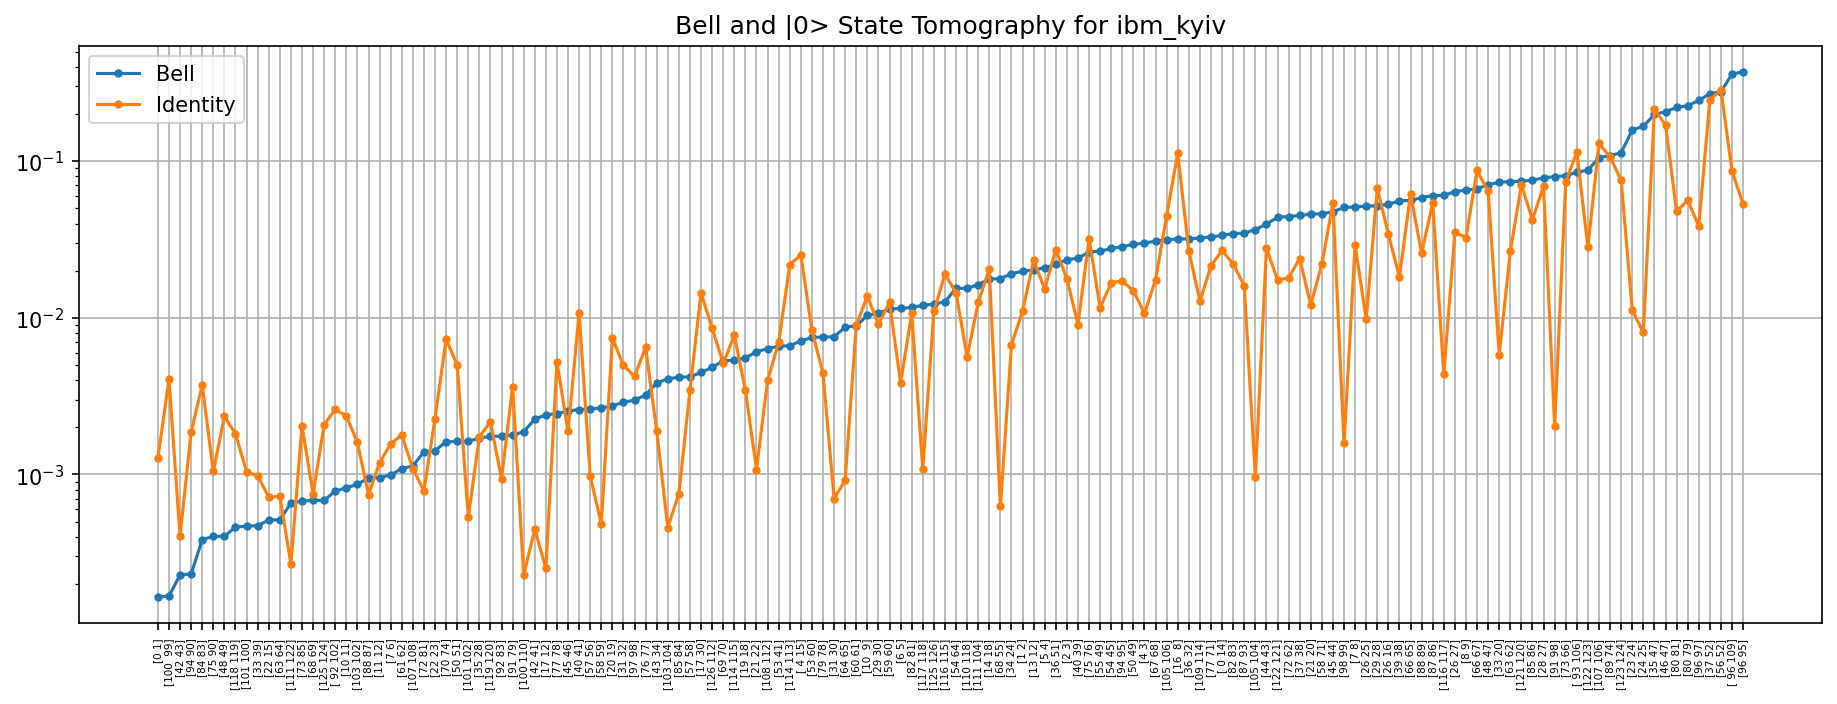

In [294]:
# plot the data ordered by Bell state fidelity (need to run the cell above first)

plt.figure(dpi=150, figsize=[15, 5])
argind = np.argsort(bell_err)
plt.semilogy(range(len(set_list)), np.array(bell_err)[argind], label="Bell", marker=".")
plt.semilogy(
    range(len(set_list)), np.array(id_err)[argind], label="Identity", marker="."
)
plt.xticks(range(len(set_list)), np.array(set_list)[argind], rotation=90, fontsize=5)
plt.grid(True)
plt.legend()
plt.title("Bell and |0> State Tomography for %s" % backend_real.name)

In [296]:
import datetime
from IPython.display import HTML, display


def qiskit_copyright(line="", cell=None):
    """IBM copyright"""
    now = datetime.datetime.now()

    html = "<div style='width: 100%; background-color:#d5d9e0;"
    html += "padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>"
    html += "<p>&copy; Copyright IBM 2017, %s.</p>" % now.year
    html += (
        "<p>This code is licensed under the Apache License, Version 2.0. You may<br>"
    )
    html += "obtain a copy of this license in the LICENSE.txt file in the root directory<br> "
    html += "of this source tree or at http://www.apache.org/licenses/LICENSE-2.0."

    html += "<p>Any modifications or derivative works of this code must retain this<br>"
    html += "copyright notice, and modified files need to carry a notice indicating<br>"
    html += "that they have been altered from the originals.</p>"
    html += "</div>"
    return display(HTML(html))


qiskit_copyright()